<a href="https://colab.research.google.com/github/Vlasovasona/Python-and-ML-Raschka/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация изображений с помощью глубоких сверточных нейронных сетей


---



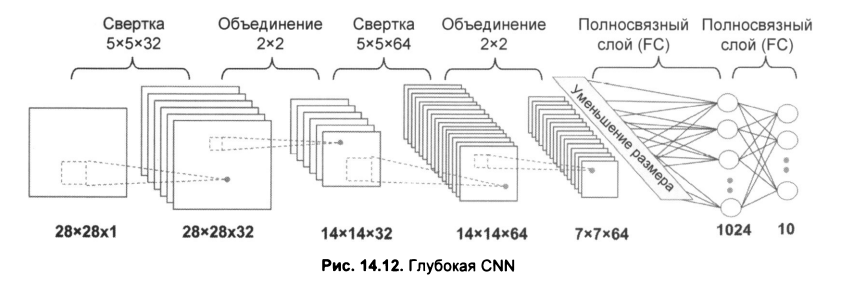

In [2]:
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch

image_path = './'
transform = transforms.Compose([
    transforms.ToTensor()
])
mnist_dataset = torchvision.datasets.MNIST(
    root = image_path, train=True, transform=transform, download=True
)
from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset,
                             torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset,
                             torch.arange(
                                 10000, len(mnist_dataset)
                             ))
mnist_test_dataset = torchvision.datasets.MNIST(
    root=image_path, train=False,
    transform=transform, download=False
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 52.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.71MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.76MB/s]


In [5]:
from torch.utils.data import DataLoader
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset,
                      batch_size,
                      shuffle=True)

valid_dl = DataLoader(mnist_valid_dataset,
                      batch_size,
                      shuffle=False)

In [6]:
model = nn.Sequential()
model.add_module(
    'conv',
    nn.Conv2d(
        in_channels=1, out_channels=32,
        kernel_size=5, padding=2
    )
)
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module(
    'conv2',
    nn.Conv2d(
        in_channels=32, out_channels=64,
        kernel_size=5, padding=2
    )
)
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

In [7]:
model.add_module('flatten', nn.Flatten())
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

In [8]:
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 10))

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
def train(model, num_epochs, train_dl, valid_dl):
  loss_hist_train = [0] * num_epochs
  accuracy_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  accuracy_hist_valid = [0] * num_epochs

  for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_dl:
      pred = model(x_batch)
      loss = loss_fn(pred, y_batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()*y_batch.size(0)
      is_correct = (
          torch.argmax(pred, dim=1) == y_batch
      ).float()
      accuracy_hist_train[epoch] += is_correct.sum()
    loss_hist_train[epoch] /= len(train_dl.dataset)
    accuracy_hist_train[epoch] /= len(train_dl.dataset)

    model.eval()
    with torch.no_grad():
      for x_batch, y_batch in valid_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
        is_correct = (
            torch.argmax(pred, dim=1) == y_batch
        ).float()
        accuracy_hist_valid[epoch] += is_correct.sum()

    loss_hist_valid[epoch] /= len(valid_dl.dataset)
    accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

    print(f'Точность эпохи {epoch+1}: '
          f'{accuracy_hist_train[epoch]:.4f} val_accuracy: '
          f'{accuracy_hist_valid[epoch]:.4f}')
  return loss_hist_train, loss_hist_valid, \
    accuracy_hist_train, accuracy_hist_valid

In [11]:
torch.manual_seed(1)
num_epochs = 12
hist = train(model, num_epochs, train_dl, valid_dl)

Точность эпохи 1: 0.9488 val_accuracy: 0.9829
Точность эпохи 2: 0.9845 val_accuracy: 0.9876
Точность эпохи 3: 0.9887 val_accuracy: 0.9883
Точность эпохи 4: 0.9912 val_accuracy: 0.9886
Точность эпохи 5: 0.9929 val_accuracy: 0.9894
Точность эпохи 6: 0.9950 val_accuracy: 0.9906
Точность эпохи 7: 0.9951 val_accuracy: 0.9859
Точность эпохи 8: 0.9963 val_accuracy: 0.9893
Точность эпохи 9: 0.9960 val_accuracy: 0.9905
Точность эпохи 10: 0.9965 val_accuracy: 0.9903
Точность эпохи 11: 0.9975 val_accuracy: 0.9893
Точность эпохи 12: 0.9970 val_accuracy: 0.9913


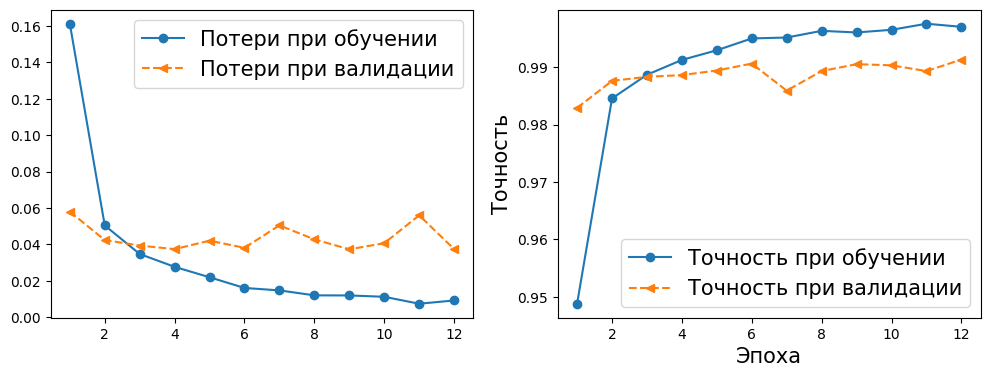

In [13]:
import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Потери при обучении')
ax.plot(x_arr, hist[1], '--<', label='Потери при валидации')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Точность при обучении')
ax.plot(x_arr, hist[3], '--<', label='Точность при валидации')
ax.legend(fontsize=15)
ax.set_xlabel('Эпоха', size=15)
ax.set_ylabel('Точность', size=15)
plt.show()